This code is a 1D test with the time dependent example given in https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html . 
<br> We use her Pytorch (because most used to it ) and we observe the evolution of the solution, especially if it gives the analytical solution $u(x, t) = e^{-t}sin(\pi x)$.

##### Import of deepxde and loading of pytorch

In [46]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [47]:
#TIme dependent example of the presentation
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import torch

In [48]:
# Check if CUDA (GPU) is available and set default tensor type to cuda, but I haven't installed cuda yet
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("/////////////////\n Tensors type on GPU \n///////////////")
print("/////////////////\n Tensors type on CPU \n///////////////")

/////////////////
 Tensors type on GPU 
///////////////
/////////////////
 Tensors type on CPU 
///////////////


c:\Users\Bilal_BM_user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [49]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr

from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [53]:
# #Geometry and residual
# geom = dde.geometry.Interval(-1, 1)
# timedomain = dde.geometry.TimeDomain(0, 1)
# geomtime = dde.geometry.GeometryXTime(geom, timedomain)
# nu = 1
# c = 1


##### Domain, and Problem definition. Analytical solution (if there's one)

In [54]:
##Geometry 
sin = torch.sin
cos = torch.cos

end_time = 1
Lx = 1
Ly = 1
geom = dde.geometry.Rectangle([0, 0], [Lx, Ly])
timedomain = dde.geometry.TimeDomain(0, end_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Source_val = 1
D = 0.001
source_box_width = 0.2

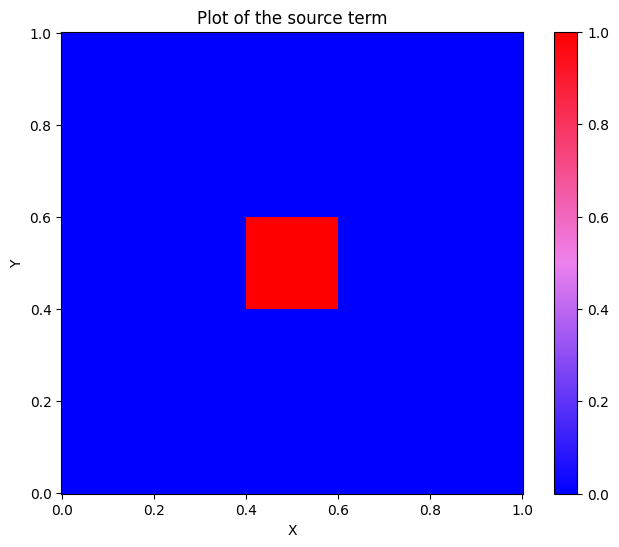

In [55]:
#The definition of the sources and plot of them
#Source places
position_source = torch.tensor([Lx*0.5, Ly*0.5], dtype=torch.float) #float type otherwise it raises an error


#Some functions to use for the source term
def close_to_source(p, position, width):
    '''position: Position of the middle of the source
        width: width of the source'''
    return (torch.isclose(p[:, 0], position[0], atol=width, rtol=0) * torch.isclose(p[:, 1], position[1], atol=width, rtol=0)).view((-1, 1))



def close_to_source_norm(p, position, width, norm):
    '''position: Position of the middle of the source
        width: width of the source'
        norm: order of the L_q norm. input is np.inf to have the infinite norm.
        (https://pytorch.org/docs/stable/generated/torch.linalg.vector_norm.html#torch.linalg.vector_norm)'''
    

    distance_tensor = torch.linalg.vector_norm(p[:, 0:2] - position, ord=norm, dim=1)
    return torch.isclose(distance_tensor, torch.zeros(1, dtype=torch.float), atol=source_box_width/2, rtol=0).view((-1, 1))




#The source_term
def source_term(p):
    return  close_to_source_norm(p, position_source, width=source_box_width, norm=np.inf)



#Plot of the Source
x = geom.uniform_points(250 * 250, True)
y_norm = source_term(torch.tensor(x)).cpu()



def plot_routine(plot_values, title):
    resolution_mesh = 250
    xi = np.linspace(0, Lx, resolution_mesh)
    yi = np.linspace(0, Ly, resolution_mesh)
    xi, yi = np.meshgrid(xi, yi)

    zi = griddata(points=(x[:, 0], x[:, 1]), values=plot_values[:, 0], xi=(xi, yi), method="linear")


    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "", ["blue", "violet", "red"]
    )
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")
    plt.colorbar()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

    plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio to have a rectangular plot
    plt.show()


plot_routine(y_norm, "Plot of the source term")


    

In [56]:
#Residual of the Pde and IC&BC.

def pde(p, C):
    """residual of the pde
    p contains the spatial coordinates x, y and the time t
    the i-th point (xi, yi, ti) is stored in p in the i-th line and we have
    p[i, 0] = xi; p[i, 1] = yi; p[i, 2] = ti
    C corresponds to C(p) the concentration at p"""

    # dC_x = dde.grad.jacobian(C, p, j=0)
    # dC_y = dde.grad.jacobian(C, p, j=1)
    dC_t = dde.grad.jacobian(C, p, j=2)

    dC_xx = dde.grad.hessian(C, p, i=0, j=0)
    dC_yy = dde.grad.hessian(C, p, i=1, j=1)



 
    return (
        - dC_t
        # - u[0] * dC_x
        # - u[1] * dC_y
        + D * (dC_xx + dC_yy)  
        + source_term(p)
    )



#Conditions (Boudary & Initial)

def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)


def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1.0)


def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1.0)


def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)


def boundary_time(x, on_initial):
    # print(x)
    return on_initial and dde.utils.isclose(x[2], 0.0)




C_top_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_top)
C_bottom_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_bottom)
C_left_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_left)
C_right_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_right)
initial_condition = dde.icbc.IC(geomtime, lambda x:0, boundary_time)



In [57]:
position_source[0].item()

0.5

In [58]:
position_source[1]+5

tensor(5.5000)

In [59]:
'''Analytical Solution of the advection-diffusion problem (from the ANACS book)'''
lower_limit_x = position_source[0] - source_box_width / 2
upper_limit_x = position_source[0] + source_box_width / 2
lower_limit_y = position_source[1] - source_box_width / 2
upper_limit_y = position_source[1] + source_box_width / 2

# def analytical_sol(p):
#     x, y, t = p
#     # f = lambda tau, v, u: S /(4*np.pi*D*(t-tau))*np.exp(-((x-u)**2 + (y-v)**2)/(4*D*(t-tau)))
#     f = lambda y_, x_: np.exp(-((x-x_)**2 + (y-y_)**2)/(4*D*(t)))
#     return (4*np.pi*t)*scipy.integrate.dblquad(f, pos_x_1, pos_x_2, pos_y_1, pos_y_2)[0]

def gaussian_source(tau, v, u, x, y, t):
    return Source_val / (4 * np.pi * D * (t - tau)) * np.exp(-((x-u)**2 + (y-v)**2) / (4 * D * (t - tau)))

def analytical_sol(p):
  x, y, t = p
  f = lambda tau, v, u: Source_val / (4 * np.pi * D * (t - tau)) * np.exp(- ((x-u)**2 + (y-v)**2) / (4 * D * (t - tau)))
  return scipy.integrate.tplquad(f, lower_limit_x, upper_limit_x, lower_limit_y, upper_limit_y, 0, t)[0]

# def analytical_sol(p):
#     x, y, t = p
#     return scipy.integrate.tplquad(gaussian_source, lower_limit_x, upper_limit_x, lower_limit_y, upper_limit_y, 0, t, args=(x, y, t))[0]





In [60]:
import time
mean_time = 0
N = 100
for k in range(N):
    start = time.time()
    analytical_sol([0.5, 0.3, 0.7])
    end = time.time()
    mean_time+=(end - start)*10000/60

mean_time = mean_time/(N)
print(mean_time)


3.413420120875042


In [61]:
np.sqrt(1000)

31.622776601683793

##### Model implementation, hyperparameter optimization

Some **documentation for the TimePDE**: https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html#deepxde.data.pde.PDE  .
Go check the deepxde.data.pde module and then, timepde (cf link column on the site). One can e.g set a specific initialization of points (train_distribution parameter).

We call this model **"model print"** as it will be the one printed by default if there isn't any hyperparameter research 

In [62]:
opti_hyperparametre= False
already_in_memory = False
make_model = True

In [63]:
#Data and model:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [
    initial_condition,
    C_top_bc,
    C_bottom_bc,
    C_left_bc,
    C_right_bc
    ],
    num_domain=500,
    num_boundary=500,
    num_initial = 200,
    num_test=100,
)

layers = [3] + [40] *3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layers, activation, initializer)
model_print = dde.Model(data, net)

In [64]:
def create_model(config):
    '''config = [nb_x_train, nb_t_train]'''
    # learning_rate, num_dense_layers, num_dense_nodes, activation = config
    nb_x_train, nb_t_train = config
    nb_x_test, nb_t_test = 100, 20
    PDE_weight, IC_weight, BC_weight = 1, 1, 1

    d=2
    learning_rate = 1e-3

    data = dde.data.TimePDE(
        geometryxtime=geomtime,
        pde=pde,
        ic_bcs=[
            initial_condition,
            C_top_bc,
            C_bottom_bc,
            C_left_bc,
            C_right_bc
                ],
        train_distribution='Hammersley',
        
        num_initial=nb_x_train,
        num_domain=nb_x_train**d*nb_t_train,
        num_boundary=4*nb_x_train*nb_t_train,
        num_test=nb_x_test**d*nb_t_test,
    )


    layer_size = [3] + [40] *3 + [1]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(layer_size, activation, initializer)

    model = dde.Model(data, net)
    model.compile("adam", lr=learning_rate, loss= 'MSE', loss_weights=[PDE_weight, IC_weight, BC_weight, BC_weight, BC_weight, BC_weight])
    return model

In [65]:


list_nb_x_train = [10]
list_nb_t_train = [10]

best_hyper_tuple = [0, 0]
best_lost_test = 1000
best_lost_epoch = 0
if opti_hyperparametre:
    for nb_x in list_nb_x_train:
        for nb_t in list_nb_t_train:
            model_hyper = create_model([nb_x, nb_t])
            early_stopping_best= dde.callbacks.ModelCheckpoint("Modeles_advdiff_2d/model_"+str(nb_x)+"_"+str(nb_t), verbose=1, save_better_only=True, period=5, monitor='test loss')
            early_stopping_var = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)

            losshistory, train_state = model_hyper.train(iterations=6000,  callbacks=[early_stopping_best, early_stopping_var])


            array_losstest = np.sum(np.array(losshistory.loss_test), axis=1)
            loss_test = np.min(array_losstest) #"Vrai loss" sans poids
            if loss_test < best_lost_test:
                best_lost_test = loss_test
                best_hyper_tuple = [nb_x, nb_t]
                best_lost_epoch = np.array(losshistory.steps)[np.argmin(array_losstest)]
                best_losshistory = losshistory
                
    print(best_hyper_tuple)
    print(best_lost_test)
    print(best_lost_epoch)
    print(best_losshistory)

In [66]:
#Restauration of the best model in term of Minimization of the test loss


if not(make_model):
    if  already_in_memory:
        best_hyper_tuple = [10, 10]
        model_print = create_model(best_hyper_tuple) 
        model_print.restore("Modeles_advdiff_2d/Best_model_2D/model_29-04_test.pt")
    else:
        model_print = create_model(best_hyper_tuple)
        losshistory_print = best_losshistory
        model_print.restore(
            save_path="Modeles_advdiff_2d/model_{nb_x}_{nb_t}-{nb_epoch}.pt".format(nb_x = best_hyper_tuple[0], nb_t = best_hyper_tuple[1], nb_epoch = best_lost_epoch))


Here is **the documentation of model.compile** : "https://deepxde.readthedocs.io/en/latest/modules/deepxde.html#deepxde.model.Model.compile". In the loss and loss_weights parameters, one must order the weights like this : weights for the pde, weights for each element of bcs. bcs is the ic bc list in the input of data. The weights for the bcs list is ordered the same way as bcs. 


In [67]:
#Computations and graph
PDE_weight, IC_weight, BC_weight = 1e-3, 1, 1

if make_model:
    model_print.compile("adam", lr=0.001, loss='MSE', loss_weights=[PDE_weight, IC_weight, BC_weight, BC_weight, BC_weight, BC_weight])
    losshistory_print, train_state = model_print.train(iterations=10000)
    dde.saveplot(losshistory_print, train_state, issave=True, isplot=True)


Compiling model...
'compile' took 0.673172 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.63e-04, 4.59e-02, 3.05e-02, 4.63e-02, 3.31e-02, 2.44e-02]    [3.31e-04, 4.59e-02, 3.05e-02, 4.63e-02, 3.31e-02, 2.44e-02]    []  
1000      [2.33e-05, 7.37e-07, 3.10e-07, 1.60e-06, 3.32e-07, 9.28e-07]    [6.19e-05, 7.37e-07, 3.10e-07, 1.60e-06, 3.32e-07, 9.28e-07]    []  
2000      [2.32e-05, 1.93e-07, 1.23e-07, 3.88e-07, 9.69e-08, 2.23e-07]    [6.22e-05, 1.93e-07, 1.23e-07, 3.88e-07, 9.69e-08, 2.23e-07]    []  
3000      [2.31e-05, 6.72e-05, 1.36e-04, 6.20e-05, 4.50e-05, 1.56e-04]    [6.19e-05, 6.72e-05, 1.36e-04, 6.20e-05, 4.50e-05, 1.56e-04]    []  
4000      [2.33e-05, 1.09e-07, 1.53e-07, 1.19e-07, 1.18e-07, 2.43e-07]    [6.24e-05, 1.09e-07, 1.53e-07, 1.19e-07, 1.18e-07, 2.43e-07]    []  
5000      [2.33e-05, 2.25e-08, 2.12e-08, 4.19e-08, 5.00e-08, 4.26e-08]

NameError: name 'losshistory' is not defined

Little difference between the plot above and the plot below. I don't know why. Normaly, they should be equal as written in the saveplot implementation: https://deepxde.readthedocs.io/en/latest/_modules/deepxde/utils/external.html#saveplot

[1.8047623e-01 2.7173444e-05 2.4272766e-05 4.8972352e-04 2.4036961e-05
 2.3493130e-05 2.3457309e-05 2.4816723e-04 2.3633298e-05 2.4417297e-05
 2.3419769e-05]


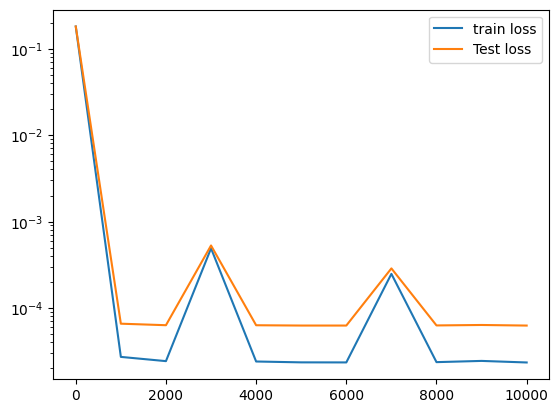

In [68]:
print(np.sum(losshistory_print.loss_train, axis=1))
plt.plot(losshistory_print.steps, np.array([np.sum(loss) for loss in losshistory_print.loss_train]), label="train loss")
plt.plot(losshistory_print.steps, np.array([np.sum(loss) for loss in losshistory_print.loss_test]), label="Test loss")
plt.yscale("log")
plt.legend()
plt.show()

#### **Visualisation of the losses**

Train Losses and Test Losses. The IC (and BC) losses for the train and test are the same as they have the same sampling points (idk why).

In [69]:
A = np.array([1, 0,5 ,2 ,5 ])
A[2:]

array([5, 2, 5])

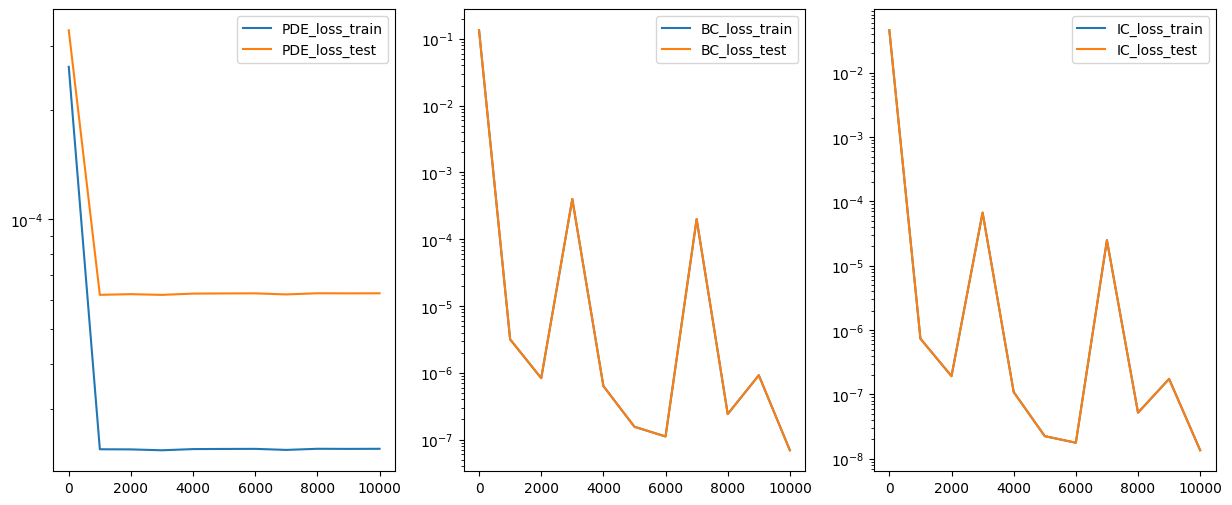

In [70]:
if not(already_in_memory):
    # if opti_hyperparametre: 
    #     array_losstrain = np.array(losshistory_print.loss_train)
    #     array_losstest = np.array(losshistory_print.loss_test)
    # else:
    #     array_losstrain = np.array(losshistory_print.loss_train)
    #     array_losstest = np.array(losshistory_print.loss_test)

    array_losstrain = np.array(losshistory_print.loss_train)
    array_losstest = np.array(losshistory_print.loss_test)
    nb_step = np.array(losshistory_print.steps)

    PDE_loss_train = array_losstrain[:, 0]
    IC_loss_train = array_losstrain[:, 1]
    BC_loss_train = np.sum(array_losstrain[:, 2:], axis=1) #ONE OF THE BC CONDITIONS. Its symetric so we consider just one 

    PDE_loss_test = array_losstest[:, 0]
    IC_loss_test = array_losstest[:, 1]
    BC_loss_test = np.sum(array_losstest[:, 2:], axis=1) #Same as above

    fig, axs = plt.subplots(1, 3, figsize= (15, 6))
    for i in range(3):
        axs[i].set_yscale('log')


    axs[0].plot(nb_step, PDE_loss_train, label="PDE_loss_train")
    axs[1].plot(nb_step, BC_loss_train, label="BC_loss_train")
    axs[2].plot(nb_step, IC_loss_train, label="IC_loss_train")

    axs[0].plot(nb_step, PDE_loss_test, label="PDE_loss_test")
    axs[1].plot(nb_step, BC_loss_test, label="BC_loss_test")
    axs[2].plot(nb_step, IC_loss_test, label="IC_loss_test")

    for i in range(3):
        axs[i].legend()

    plt.legend()
    plt.show()


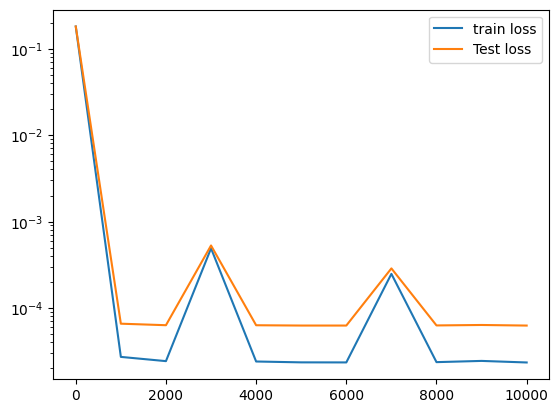

In [71]:
if not(already_in_memory):
    if False:
        Train_loss = PDE_weight*PDE_loss_train + BC_weight* BC_loss_train + IC_weight*IC_loss_train
        Test_loss = PDE_weight* PDE_loss_test + BC_weight* BC_loss_test + IC_weight*IC_loss_test
    else:
        Train_loss = PDE_loss_train + BC_loss_train + IC_loss_train
        Test_loss = PDE_loss_test + BC_loss_test + IC_loss_test
        
    plt.plot(nb_step, Train_loss, label="train loss")
    plt.plot(nb_step, Test_loss, label="Test loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

#### Analytical solution or Finite Element Solution

In [76]:
use_of_FE = True
use_of_anal_sol = False

In [77]:
print(" MODEL PRINT IS THE MODEL COMPUTED WITH THE HYPERPARAMETERS RESEARCH: ", opti_hyperparametre)
print(" MODEL PRINT IS THE MODEL COMPUTED AT THE BEGINNING OF THE CODE: ", not(opti_hyperparametre))

 MODEL PRINT IS THE MODEL COMPUTED WITH THE HYPERPARAMETERS RESEARCH:  False
 MODEL PRINT IS THE MODEL COMPUTED AT THE BEGINNING OF THE CODE:  True


Some Matplotlib link for placing colorbars: https://matplotlib.org/stable/users/explain/axes/colorbar_placement.html

In [111]:
501*101

50601

In [116]:

# time_list = [0.3]
# time_1, time_2, time_3, time_4, = 0, 0.3, 0.7, 1.

Use_max = False
resolution_mesh_x = 101
resolution_mesh_y = 501
t_1 = 0.3

# Define the spatial domain where you want to evaluate the function
# x = np.linspace(-1, 1, 50)

# x = geom.uniform_points(resolution_mesh_x*resolution_mesh_y, True)
print(x.shape)
xi = np.linspace(0, Lx, resolution_mesh_x)
yi = np.linspace(0, Ly, resolution_mesh_y)
x = np.array( [ [x, y] for x in xi for y in yi])

xi, yi = np.meshgrid(xi, yi)

C_max = 0.7 #Max in absolute value to scale the color of the graph


# p_1 = np.c_[x, np.array([time_1] * x.shape[0])]
# p_2 = np.c_[x, np.array([time_2] * x.shape[0])]
# p_3 = np.c_[x, np.array([time_3] * x.shape[0])]
# p_4 = np.c_[x, np.array([time_4] * x.shape[0])]

print("Number of points :", p.shape[0])

p = np.c_[x, np.array([t_1] * x.shape[0])]


# Prediction of the model
u_t1 = model_print.predict(p)[:,0]
print(u_t1.shape)



(50601, 2)
Number of points : 50601
(50601,)


In [117]:
if use_of_anal_sol: 
    #Analytical solution computation
    # time_list = [0, 0.3, 0.7, 1.]


    batch_size = 50
    a_t1 = np.zeros(len(p_1))
    a_t2 = np.zeros(len(p_2))
    a_t3 = np.zeros(len(p_3))
    a_t4 = np.zeros(len(p_4))
    counter_batch = 0

    for i in range(0, len(p_2), batch_size):
        print( "batch n", counter_batch)
        start = time.time()
        batch_points = p_2[i:i+batch_size]
        a_t2[i:i+batch_size] = np.apply_along_axis(analytical_sol, axis=1, arr=batch_points)
        end = time.time()
        counter_batch += 1
        print("Time per batch: ", (end-start))

    np.save("Modeles_advdiff_2d/saved_arrays/array_save_time_3.npy", arr=a_t2)


In [118]:
if use_of_anal_sol:
    loaded_array = np.load("Modeles_advdiff_2d/saved_arrays/array_save.npy")
    print(loaded_array)

In [119]:
if use_of_FE:
    dataset_FE = xr.open_dataset("sim_v1ms_D0.01.nc")
    print(dataset_FE)
    print("\n")
    print(dataset_FE.dims)

<xarray.Dataset> Size: 102MB
Dimensions:      (time: 101, z: 1, y: 101, x: 501)
Dimensions without coordinates: time, z, y, x
Data variables:
    scalar1      (time, z, y, x) float32 20MB ...
    AOD_scalar1  (time, y, x) float32 20MB ...
    Ux           (time, z, y, x) float32 20MB ...
    Uy           (time, z, y, x) float32 20MB ...
    Uz           (time, z, y, x) float32 20MB ...


FrozenMappingWarningOnValuesAccess({'time': 101, 'z': 1, 'y': 101, 'x': 501})


In [120]:
if use_of_FE:  

    
    FE_dataarray = dataset_FE.data_vars['scalar1']
    FE_np_array = FE_dataarray.to_numpy()
    print(np.nanmax(FE_np_array))
    nan_arr = np.isnan(FE_np_array)
    num_nan = np.sum(nan_arr)
    print("Proportion of nan elements: ", num_nan/np.size(FE_np_array))

    #Convertion without nans 
    FE_np_array = np.nan_to_num(FE_np_array, nan=0)
    print(np.max(FE_np_array))

    #DIMENSIONS : time101; z: 1; y: 101; x: 501
    print(FE_np_array.shape)
    FE_np_array = FE_np_array[:, 0, :, :]
    print(FE_np_array.shape)
    print(FE_np_array [0])

    a_t1 = FE_np_array[0, :, :].flatten()
    print(a_t1.shape)


8.528795
Proportion of nan elements:  7.904982114977965e-05
8.528795
(101, 1, 101, 501)
(101, 101, 501)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(50601,)


#### **Fixed time: plots of solutions, visualization of the errors.**

##### Plots and error for a fixed given time

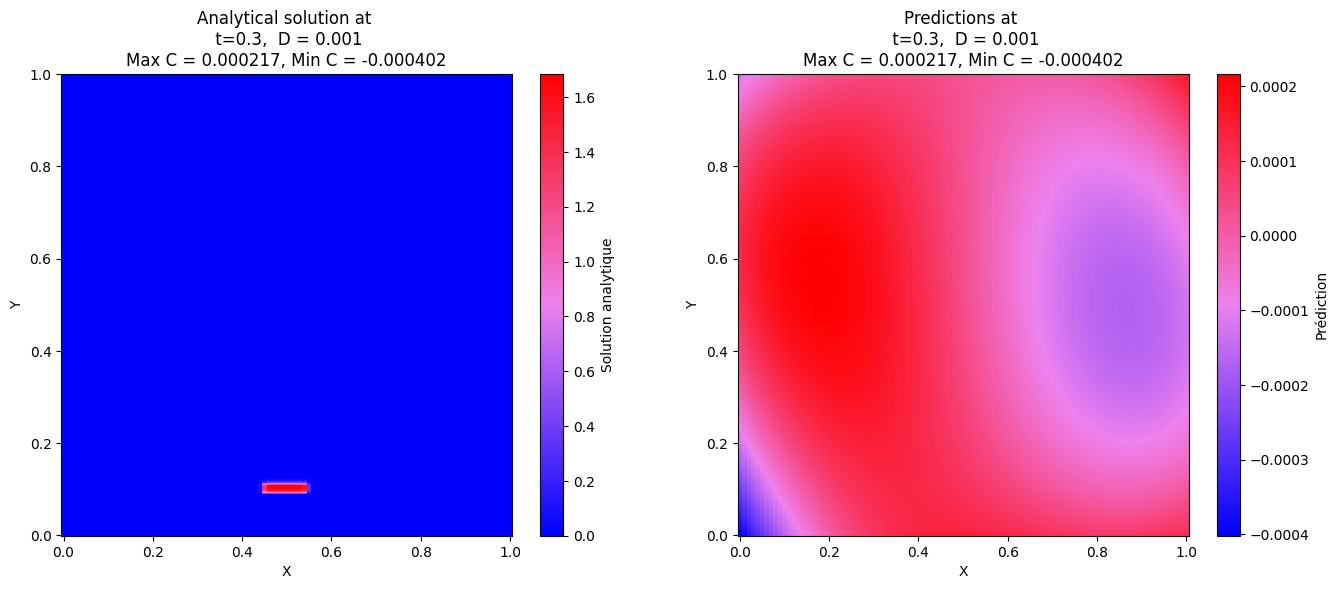

In [121]:
#Plot of analytical or FE computed solution and PINNs computed solution

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["blue", "violet", "red"]
)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

zi = griddata((x[:, 0], x[:, 1]), u_t1, (xi, yi), method="linear")
zi_a = griddata((x[:, 0], x[:, 1]), a_t1, (xi, yi), method="linear")

plt.figure(figsize=(8, 6))
if Use_max:
    ax_0_pcolormesh = axs[0].pcolormesh(xi, yi, zi_a, cmap=cmap, vmin=-1*C_max, vmax=C_max, shading="auto")
    ax_1_pcolormesh = axs[1].pcolormesh(xi, yi, zi, cmap=cmap, vmin=-1*C_max, vmax=C_max, shading="auto")
else:
    ax_0_pcolormesh = axs[0].pcolormesh(xi, yi, zi_a, cmap=cmap, shading="auto")
    ax_1_pcolormesh = axs[1].pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")
    
fig.colorbar(ax_0_pcolormesh, label="Solution analytique")
fig.colorbar(ax_1_pcolormesh, label="Prédiction")

axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")

title_plot_0 = "Analytical solution " + "at \n t={time},  D = {Diffusion}\n" + "Max C = {max}, Min C = {min}"
title_plot = "Predictions " + "at \n t={time},  D = {Diffusion}\n" + "Max C = {max}, Min C = {min}"

axs[0].set_title(title_plot_0.format(time=t_1, Diffusion = D, max = int(np.max(u_t1)*10e5)/10e5, min = int(np.min(u_t1)*10e5)/10e5))
axs[1].set_title(title_plot.format(time=t_1, Diffusion = D, max = int(np.max(u_t1)*10e5)/10e5, min = int(np.min(u_t1)*10e5)/10e5))

plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio to have a rectangular plot
plt.close()
plt.show()


In [121]:
'''L2 difference computation'''
space_step = 100
x = geom.uniform_points(space_step**2, boundary=True)

Sample_error = np.c_[x, np.ones(x.shape[0])*t_1]
y_true = analytical_sol(Sample_error)
y_pred = model_print.predict(Sample_error)[:, 0] #Watch out: shape of model.predict is  (M, 1)
# y_pred = np.zeros(y_pred.shape)

# print(np.shape(y_true))
# print(np.shape(y_pred))


error= dde.metrics.l2_relative_error(y_true, y_pred) 
# print(y_pred)
print("\nDeepXDE-made relative error: ", error, "%")


#Hand-made verifications
error_hand_made = np.linalg.norm(y_true-y_pred)/np.linalg.norm(y_true) #default 2-norm
print("\nHand-made relative error ", error_hand_made, "%")

()
(10000,)

DeepXDE-made relative error:  100.0 %

Hand-made relative error  100.0 %


##### Plot and error in all the time. Animations

In [20]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [21]:
# Define the time domain
t = np.linspace(0, 1, 30)
delta_t = 0.1 # time step for the animation
T_anim = end_time #animation end time
x = geom.uniform_points(250 * 250, True)



resolution_mesh = 250
xi = np.linspace(0, Lx, resolution_mesh)
yi = np.linspace(0, Ly, resolution_mesh)
xi, yi = np.meshgrid(xi, yi)

p = np.c_[x, np.array([0] * x.shape[0])]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["blue", "violet", "red"]
)

# Initialize the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))


u_t1 = model_print.predict(p)[:,0]
a_t1 = np.ones(u_t1.shape)
# a_x_t1 = analytical_sol(x, 0*np.ones_like(x), N=Order)
# diff = a_x_t1 - u_x_t1[:, 0]


#initilize the colormeshes
zi = griddata((x[:, 0], x[:, 1]), u_t1, (xi, yi), method="linear")
zi_a = griddata((x[:, 0], x[:, 1]), a_t1, (xi, yi), method="linear")

pcolormesh_a = axs[0].pcolormesh(xi, yi, zi_a, cmap=cmap, shading="auto")
pcolormesh_u = axs[1].pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")

fig.colorbar(pcolormesh_a, label="Solution analytique")
fig.colorbar(pcolormesh_u, label="Prédiction")


# Update function for the animation
def update(frame):
    #Two graphs
    t_1 = t[frame]
    
    
    p = np.c_[x, np.array([t_1] * x.shape[0])]
    u_t1 = model_print.predict(p)[:,0]
    a_t1 = np.ones(u_t1.shape)
    
    zi = griddata((x[:, 0], x[:, 1]), u_t1, (xi, yi), method="linear")
    zi_a = griddata((x[:, 0], x[:, 1]), a_t1, (xi, yi), method="linear")

    # line_analytical.set_data(x, a_x_t1)
    # line_computed.set_data(x, u_x_t1)
    
    axs[0].set_title('Analytical solution at time {}'.format(t_1))
    axs[1].set_title('Computed solution at time {}'.format(t_1))
    
    pcolormesh_a.set_array(zi_a.ravel())
    pcolormesh_u.set_array(zi.ravel())
    return pcolormesh_a, pcolormesh_u




# Create the animations

animation = FuncAnimation(fig, update, frames=len(t))
plt.close() #to avoid having another plot after the animation
# Show the animation
HTML(animation.to_jshtml())




In [22]:
# Define the time domain
t = np.linspace(0, 1, 30)
delta_t = 0.1 # time step for the animation
T_anim = end_time #animation end time
x = geom.uniform_points(250 * 250, True)



resolution_mesh = 250
xi = np.linspace(0, Lx, resolution_mesh)
yi = np.linspace(0, Ly, resolution_mesh)
xi, yi = np.meshgrid(xi, yi)

p = np.c_[x, np.array([0] * x.shape[0])]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["blue", "violet", "red"]
)

# Initialize the figure and subplots

u_t1 = model_print.predict(p)[:,0]
a_t1 = np.ones(u_t1.shape)
# a_x_t1 = analytical_sol(x, 0*np.ones_like(x), N=Order)

diff = a_t1 - u_t1


#initilize the colormeshes
fig, ax= plt.subplots(1, 1)
zi_diff = griddata((x[:, 0], x[:, 1]), diff, (xi, yi), method="linear")

pcolormesh_diff = ax.pcolormesh(xi, yi, zi_diff, cmap=cmap, shading="auto")

fig.colorbar(pcolormesh_diff, label="Difference")


# Update function for the animation
def update(frame):
    #Two graphs
    t_1 = t[frame]
    
    
    p = np.c_[x, np.array([t_1] * x.shape[0])]
    u_t1 = model_print.predict(p)[:,0]
    a_t1 = np.ones(u_t1.shape)
    diff =  a_t1 - u_t1
    zi_diff = griddata((x[:, 0], x[:, 1]), diff, (xi, yi), method="linear")
    
    ax.set_title('Analytical - computed solution {}'.format(t_1))
    
    pcolormesh_diff.set_array(zi_diff.ravel())
    return pcolormesh_diff, 




# Create the animations

animation = FuncAnimation(fig, update, frames=len(t))
plt.close() #to avoid having another plot after the animation
# Show the animation
HTML(animation.to_jshtml())





**Error Checks**

In [23]:
from numpy import linalg

In [24]:
'''L2 difference computation'''
space_step = 100
time_step = 100


x = geomtime.uniform_points(space_step**2*time_step, boundary=True)
# y_true = analytical_sol(x[:,0], x[:,1], N=500)
y_true = analytical_sol(x)
y_pred = model_print.predict(x)[:, 0] #Watch out: shape of model.predict is  (M, 1).
print(np.shape(y_pred))
print(np.shape(y_true))


error= dde.metrics.l2_relative_error(y_true, y_pred) 
# print(y_pred)
print("\nDeepXDE-made relative error: ", error)


#Hand-made verifications
error_hand_made = np.linalg.norm(y_true-y_pred)/np.linalg.norm(y_true) #default 2-norm
print("\nHand-made relative error ", error_hand_made)

(1024000,)
()

DeepXDE-made relative error:  992.141357421875

Hand-made relative error  992.141357421875
